In [1]:
import wandb

import os
import cv2
import math
import random
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
import open3d as o3d
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from Hydranet import Hydranet

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
wandb.login()
with wandb.init(project="CamVid", name="fetch_artifacts", entity="hydranet"):
    data_artifact = wandb.use_artifact('tiny-kitti-test-set:latest')
    model_artifact = wandb.use_artifact('kitti-hydranet:latest')
    data_directory = data_artifact.download()
    model_directory = model_artifact.download()

ERROR - 2022-01-28 06:50:16,421 - jupyter - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geekyrakshit (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact tiny-kitti-test-set:latest, 84.52MB. 110 files... Done. 0:0:0


In [3]:
data_directory, model_directory

('./artifacts/tiny-kitti-test-set:v0', './artifacts/kitti-hydranet:v0')

In [4]:
hydranet = Hydranet(2, 6)
ckpt = torch.load(os.path.join(model_directory, "ExpKITTI_joint.ckpt"), map_location='cpu')
hydranet.enc.load_state_dict(ckpt["state_dict"], strict=False)
hydranet.dec.load_state_dict(ckpt["state_dict"], strict=False)
hydranet.eval()

Hydranet(
  (enc): Mobilenet_backbone(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (layer2): Sequential(
      (0): InvertedResidualBlock(
        (output): Sequential(
          (0): Sequential(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (2): Sequential(
            (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias

In [5]:
CONFIGS = {
    "scale": 1./255,
    "mean": [0.485, 0.456, 0.406],
    "std":  [0.229, 0.224, 0.225],
    "num_classes": 6
}

image_mean = np.array(CONFIGS["mean"]).reshape((1, 1, 3))
image_std = np.array(CONFIGS["std"]).reshape((1, 1, 3))
color_map = np.load(os.path.join(model_directory, 'cmap_kitti.npy'))
num_classes = CONFIGS["num_classes"]

In [6]:
def inference_pipeline(image):
    with torch.no_grad():
        preprocessed_image = (image * CONFIGS["scale"] - image_mean) / image_std
        image_variable = Variable(
            torch.from_numpy(preprocessed_image.transpose(2, 0, 1)[None]),
            requires_grad=False
        ).float()
        depth, segmentation_map = hydranet(image_variable)
        segmentation_map = cv2.resize(
            segmentation_map[0].cpu().data.numpy().transpose(1,2,0),
            image.shape[:2][::-1],
            interpolation=cv2.INTER_CUBIC
        )
        raw_mask = segmentation_map.argmax(axis=2)
        segmentation_map = color_map[raw_mask].astype(np.uint8)
        depth = cv2.resize(
            depth[0].cpu().data.numpy().transpose(1,2,0),
            image.shape[:2][::-1],
            interpolation=cv2.INTER_CUBIC
        )
        raw_depth = depth
        depth = np.abs(depth).astype(np.uint8)
        return depth, raw_mask, segmentation_map

In [7]:
def get_point_cloud(image, depth, segmentation_map, sample_percentage):
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(segmentation_map),
        o3d.geometry.Image(depth),
        convert_rgb_to_intensity=False
    )
    intrinsics = o3d.camera.PinholeCameraIntrinsic(width = 1242, height = 375, fx = 721., fy = 721., cx = 609., cy = 609.)
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
    point_cloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    pc_with_image = np.concatenate([np.asarray(point_cloud.points) * 1e5, image.reshape(-1, 3)], axis=-1)
    pc_with_mask = np.concatenate([np.asarray(point_cloud.points) * 1e5, segmentation_map.reshape(-1, 3)], axis=-1)
    num_points = len(pc_with_image)
    num_sampled_points = num_points * sample_percentage // 100
    print(f"Sampling {num_sampled_points} points from each point cloud....")
    sampled_indices = random.sample(list(range(num_points)), num_sampled_points)
    pc_with_image = pc_with_image[sampled_indices]
    pc_with_mask = pc_with_mask[sampled_indices]
    return pc_with_image, pc_with_mask

In [8]:
images_files = glob(os.path.join(data_directory, "*.png"))
len(images_files)

110

In [9]:
def plot_inference(images_files, idx):
    image_path = images_files[idx]
    image = np.array(Image.open(image_path))
    depth, _, segmentation_map = inference_pipeline(image)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=30)
    ax2.imshow(segmentation_map)
    ax2.set_title('Predicted Segmentation', fontsize=30)
    ax3.imshow(depth, cmap="viridis", vmin=0, vmax=40)
    ax3.set_title("Predicted Depth", fontsize=30)
    plt.show()

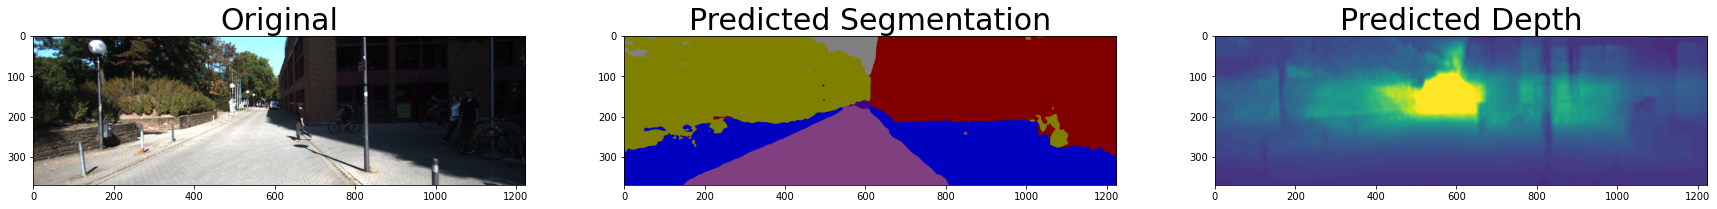

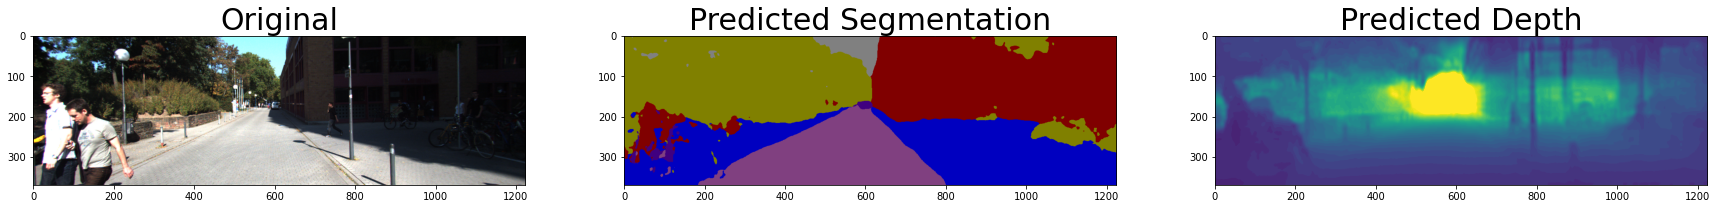

In [10]:
for i in range(2):
    plot_inference(images_files, i)

In [11]:
with wandb.init(project="CamVid", name="kitti-hydranet-results", entity="hydranet"):
    table_data = []
    for image_file in tqdm(images_files[10: 20]):
        image = Image.open(image_file)
        depth, raw_mask, segmentation_map = inference_pipeline(np.array(image))
        wandb_mask_image = wandb.Image(
            image, masks={
                "test": {
                    "mask_data": raw_mask,
                    "class_labels": {
                        0: "sky",
                        1: "buildings",
                        2: "road",
                        3: "sidewalk",
                        4: "vegetation",
                        5: "cars",
                    }
                }
            }
        )
        colored_depth = plt.get_cmap("viridis")(depth)
        table_data.append([wandb.Image(image), wandb.Image(colored_depth), wandb_mask_image])
    wandb.log({
        "KITTI-Test-Results": wandb.Table(
            data=table_data,
            columns=["RGB Image", "Depth Map", "Segmentation Result"]
        )
    })
    image = Image.open(images_files[14])
    depth, raw_mask, segmentation_map = inference_pipeline(np.array(image))
    pc_with_image, pc_with_mask = get_point_cloud(
        np.array(image), depth, segmentation_map, sample_percentage=25
    )
    wandb.log({
        "point_clouds": [
            wandb.Object3D({
                "type": "lidar/beta",
                "points": pc_with_image
            }),
            wandb.Object3D({
                "type": "lidar/beta",
                "points": pc_with_mask
            }),
        ]
    })

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.10s/it]


Sampling 113220 points from each point cloud....
